# 2.2 CNN Hyperparameters

### Contents:
1. Install Libraries
2. Import Libraries
3. Import Datasets
4. Prepare Data
5. Split Data
6. CNN Model
7. CNN w/ Added Convolution & Pooling Layers
8. RNN Model
9. LSTM Model
10. RNN Model w/ Scaled Data
11. Export Datasets

## 1. Install Libraries

In [321]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [59]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [61]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [63]:
pip install bayesian-optimization

Note: you may need to restart the kernel to use updated packages.


In [65]:
pip install scikeras

Note: you may need to restart the kernel to use updated packages.


## 2. Import Libraries

In [249]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import operator
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from numpy import unique
from numpy import reshape
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from tensorflow.keras.layers import Conv1D, Conv2D, Dense, Dropout, BatchNormalization, Flatten, MaxPooling1D, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.utils import to_categorical
from math import floor
from sklearn.metrics import make_scorer, accuracy_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

## 3. Import Datasets

In [251]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [253]:
path = os.getcwd()
path

'/Users/kirstencurrie/ClimateWins Analysis/02 Scripts'

In [255]:
path = '/Users/kirstencurrie/ClimateWins Analysis'

In [257]:
climate = pd.read_parquet(os.path.join(path, '01 Datasets', '02 Prepared Data', 'weather_unscaled_clean.parquet'))
climate.shape

(22950, 137)

In [259]:
pleasant = pd.read_csv(os.path.join(path, '01 Datasets', '01 Original Data', 'Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv'))
pleasant.head(1)

,DATE,BASEL_pleasant_weather,BELGRADE_pleasant_weather,BUDAPEST_pleasant_weather,DEBILT_pleasant_weather,DUSSELDORF_pleasant_weather,HEATHROW_pleasant_weather,KASSEL_pleasant_weather,LJUBLJANA_pleasant_weather,MAASTRICHT_pleasant_weather,MADRID_pleasant_weather,MUNCHENB_pleasant_weather,OSLO_pleasant_weather,SONNBLICK_pleasant_weather,STOCKHOLM_pleasant_weather,VALENTIA_pleasant_weather
0,19600101,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 4. Prepare Data

In [261]:
#Drop Date & Month Columns from weather observations
df = climate.drop(['DATE', 'MONTH'], axis=1)
df.shape

(22950, 135)

In [263]:
#Drop Date column from pleasant weather rating
pl = pleasant.drop(['DATE'], axis=1)
pl.shape

(22950, 15)

## 5. Split & Reshape Data

In [265]:
#Set cleaned, unscaled weather data to X and pleasant ratings to y
X = df
y = pl

In [267]:
#Convert df's to arrays
X = np.array(X)
y = np.array(y)

In [269]:
#Reshape X as a 3D object
X = X.reshape(-1,15,9)
X.shape

(22950, 15, 9)

In [271]:
y.shape

(22950, 15)

In [273]:
# Use argmax to transform y

y =  np.argmax(y, axis = 1)
y

array([0, 0, 0, ..., 0, 0, 0])

In [275]:
y.shape

(22950,)

In [277]:
# Check y layout

from sklearn.utils.multiclass import type_of_target
type_of_target(y)

'multiclass'

In [279]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42)

In [281]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(17212, 15, 9) (17212,)
(5738, 15, 9) (5738,)


## 6. CNN Model

In [283]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = 15 # Number of weather stations
# Make scorer accuracy
score_acc = make_scorer(accuracy_score)

In [285]:
# Create function

def bay_area(neurons, activation, kernel, optimizer, learning_rate, batch_size, epochs,
              layers1, layers2, normalization, dropout, dropout_rate): 
    optimizerL = ['SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl','SGD']
    #optimizerD= {'Adam':Adam(lr=learning_rate), 'SGD':SGD(lr=learning_rate),
                 #'RMSprop':RMSprop(lr=learning_rate), 'Adadelta':Adadelta(lr=learning_rate),
                 #'Adagrad':Adagrad(lr=learning_rate), 'Adamax':Adamax(lr=learning_rate),
                 #'Nadam':Nadam(lr=learning_rate), 'Ftrl':Ftrl(lr=learning_rate)}
    activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu',
                   'elu', 'exponential', LeakyReLU,'relu']
    
    neurons = round(neurons)
    kernel = round(kernel)
    activation = activationL[round(activation)]  #optimizerD[optimizerL[round(optimizer)]]
    optimizer = optimizerL[round(optimizer)]
    batch_size = round(batch_size)
    
    epochs = round(epochs)
    layers1 = round(layers1)
    layers2 = round(layers2)
    
    def cnn_model():
        model = Sequential()
        model.add(Conv1D(neurons, kernel_size=kernel,activation=activation, input_shape=(timesteps, input_dim)))
        #model.add(Conv1D(32, kernel_size=1,activation='relu', input_shape=(timesteps, input_dim)))
        
        if normalization > 0.5:
            model.add(BatchNormalization())
        for i in range(layers1):
            model.add(Dense(neurons, activation=activation)) #(neurons, activation=activation))
        if dropout > 0.5:
            model.add(Dropout(dropout_rate, seed=123))
        for i in range(layers2):
            model.add(Dense(neurons, activation=activation))
        model.add(MaxPooling1D())
        model.add(Flatten())
        model.add(Dense(n_classes, activation='softmax')) #sigmoid softmax
        #model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy']) #categorical_crossentropy
        model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy']) #categorical_crossentropy
        return model
    es = EarlyStopping(monitor='accuracy', mode='max', verbose=2, patience=20)
    nn = KerasClassifier(build_fn=cnn_model, epochs=epochs, batch_size=batch_size, verbose=2)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
    score = cross_val_score(nn, X_train, y_train, scoring=score_acc, cv=kfold, fit_params={'callbacks':[es]}).mean()
    return score

In [287]:
start = time.time()
params ={
    'neurons': (10, 100),
    'kernel': (1, 3),
    'activation':(0, 9), 
    'optimizer':(0,7),
    'learning_rate':(0.01, 1),
    'batch_size': (200, 1000), 
    'epochs':(20, 50),
    'layers1':(1,3),
    'layers2':(1,3),
    'normalization':(0,1),
    'dropout':(0,1),
    'dropout_rate':(0,0.3)
}
# Run Bayesian Optimization
nn_opt = BayesianOptimization(bay_area, params, random_state=42)
nn_opt.maximize(init_points=15, n_iter=4) 
print('Search took %s minutes' % ((time.time() - start)/60))

|   iter    |  target   | activa... | batch_... |  dropout  | dropou... |  epochs   |  kernel   |  layers1  |  layers2  | learni... |  neurons  | normal... | optimizer |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Epoch 1/25
15/15 - 1s - 59ms/step - accuracy: 0.6085 - loss: 2.7038
Epoch 2/25
15/15 - 1s - 34ms/step - accuracy: 0.6440 - loss: 2.7004
Epoch 3/25
15/15 - 1s - 34ms/step - accuracy: 0.6440 - loss: 2.6970
Epoch 4/25
15/15 - 1s - 35ms/step - accuracy: 0.6440 - loss: 2.6942
Epoch 5/25
15/15 - 1s - 34ms/step - accuracy: 0.6440 - loss: 2.6917
Epoch 6/25
15/15 - 1s - 39ms/step - accuracy: 0.6440 - loss: 2.6894
Epoch 7/25
15/15 - 1s - 33ms/step - accuracy: 0.6440 - loss: 2.6873
Epoch 8/25
15/15 - 1s - 34ms/step - accuracy: 0.6440 - loss: 2.6853
Epoch 9/25
15/15 - 0s - 33ms/step - accuracy: 0.6440 - loss: 2.6834
Epoch 10/25
15/15 - 0s - 33ms/step - accuracy: 0

ValueError: Input y contains NaN.

In [289]:
optimum = nn_opt.max['params']
learning_rate = optimum['learning_rate']

activationL = ['relu', 'sigmoid', 'softplus', 'softsign', 'tanh', 'selu', 'elu', 'exponential', LeakyReLU, 'relu']
optimum['activation'] = activationL[round(optimum['activation'])]

optimum['batch_size'] = round(optimum['batch_size'])
optimum['epochs'] = round(optimum['epochs'])
optimum['layers1'] = round(optimum['layers1'])
optimum['layers2'] = round(optimum['layers2'])
optimum['neurons'] = round(optimum['neurons'])

optimizerL = ['Adam', 'SGD', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl', 'Adam']
optimizerD = {
    'Adam': Adam(learning_rate=learning_rate),
    'SGD': SGD(learning_rate=learning_rate),
    'RMSprop': RMSprop(learning_rate=learning_rate),
    'Adadelta': Adadelta(learning_rate=learning_rate),
    'Adagrad': Adagrad(learning_rate=learning_rate),
    'Adamax': Adamax(learning_rate=learning_rate),
    'Nadam': Nadam(learning_rate=learning_rate),
    'Ftrl': Ftrl(learning_rate=learning_rate)
}
optimum['optimizer'] = optimizerD[optimizerL[round(optimum['optimizer'])]]
optimum

{'activation': 'softsign',
 'batch_size': 460,
 'dropout': 0.7296061783380641,
 'dropout_rate': 0.19126724140656393,
 'epochs': 47,
 'kernel': 1.9444298503238986,
 'layers1': 1,
 'layers2': 2,
 'learning_rate': 0.7631771981307285,
 'neurons': 61,
 'normalization': 0.770967179954561,
 'optimizer': <keras.src.optimizers.adadelta.Adadelta at 0x3c0a94a10>}

## 7. Optimizing CNN Model

In [237]:
from keras import backend as K
K.clear_session()

In [291]:
#Run with optimization
epochs = 47
batch_size = 460

timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = 15

layers1 = 1
layers2 = 2
activation = 'softsign'
kernel = int(round(1.9444298503238986))  # Rounded kernel size for Conv1D
neurons = 61
normalization = 0.770967179954561
dropout = 0.7296061783380641
dropout_rate = 0.19126724140656393
optimizer = Adadelta(learning_rate=0.7631771981307285)  # Instantiate RMSprop with learning rate

model = Sequential()
model.add(Conv1D(neurons, kernel_size=kernel, activation=activation, input_shape=(timesteps, input_dim)))

if normalization > 0.5:
    model.add(BatchNormalization())

for i in range(layers1):
    model.add(Dense(neurons, activation=activation))

if dropout > 0.5:
    model.add(Dropout(dropout_rate))

for i in range(layers2):
    model.add(Dense(neurons, activation=activation))

model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(n_classes, activation='softmax')) 

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [293]:
model.summary()

Model: "sequential_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_76 (Conv1D)              │ (None, 14, 61)         │         1,159 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 14, 61)         │           244 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_384 (Dense)               │ (None, 14, 61)         │         3,782 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 14, 61)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_385 (Dense)               │ (None, 14, 61)         │         3,782 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_386 (Dense)               │ (None, 14, 61)         │         3,782 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_76 (MaxPooling1D) │ (None, 7, 61)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_76 (Flatten)            │ (None, 427)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_387 (Dense)               │ (None, 15)             │         6,420 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,169 (74.88 KB)

 Trainable params: 19,047 (74.40 KB)

 Non-trainable params: 122 (488.00 B)

In [295]:
# Put the y_test set back into a one-hot configuration

y_train_one_hot = to_categorical(y_train, num_classes=15)

In [297]:
# Check shapes

print(f'X_train shape: {X_train.shape}')
print(f'y_train_one_hot shape: {y_train_one_hot.shape}')

X_train shape: (17212, 15, 9)
y_train_one_hot shape: (17212, 15)


In [299]:
# Compile the model with categorical_crossentropy

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [325]:
# Fit the model to the data

history = model.fit(X_train, y_train_one_hot, batch_size=batch_size, epochs=epochs, verbose=2, validation_split=0.2)

Epoch 1/47
30/30 - 0s - 15ms/step - accuracy: 0.8494 - loss: 0.4222 - val_accuracy: 0.8333 - val_loss: 0.4712
Epoch 2/47
30/30 - 0s - 13ms/step - accuracy: 0.8521 - loss: 0.4137 - val_accuracy: 0.8327 - val_loss: 0.4519
Epoch 3/47
30/30 - 0s - 14ms/step - accuracy: 0.8542 - loss: 0.4142 - val_accuracy: 0.8249 - val_loss: 0.4926
Epoch 4/47
30/30 - 0s - 14ms/step - accuracy: 0.8538 - loss: 0.4141 - val_accuracy: 0.8408 - val_loss: 0.4574
Epoch 5/47
30/30 - 0s - 14ms/step - accuracy: 0.8555 - loss: 0.4102 - val_accuracy: 0.8519 - val_loss: 0.4066
Epoch 6/47
30/30 - 0s - 14ms/step - accuracy: 0.8581 - loss: 0.4046 - val_accuracy: 0.8391 - val_loss: 0.4383
Epoch 7/47
30/30 - 0s - 14ms/step - accuracy: 0.8554 - loss: 0.4042 - val_accuracy: 0.8458 - val_loss: 0.4278
Epoch 8/47
30/30 - 0s - 14ms/step - accuracy: 0.8616 - loss: 0.3956 - val_accuracy: 0.7906 - val_loss: 0.5771
Epoch 9/47
30/30 - 0s - 14ms/step - accuracy: 0.8547 - loss: 0.4081 - val_accuracy: 0.8240 - val_loss: 0.5065
Epoch 10/4

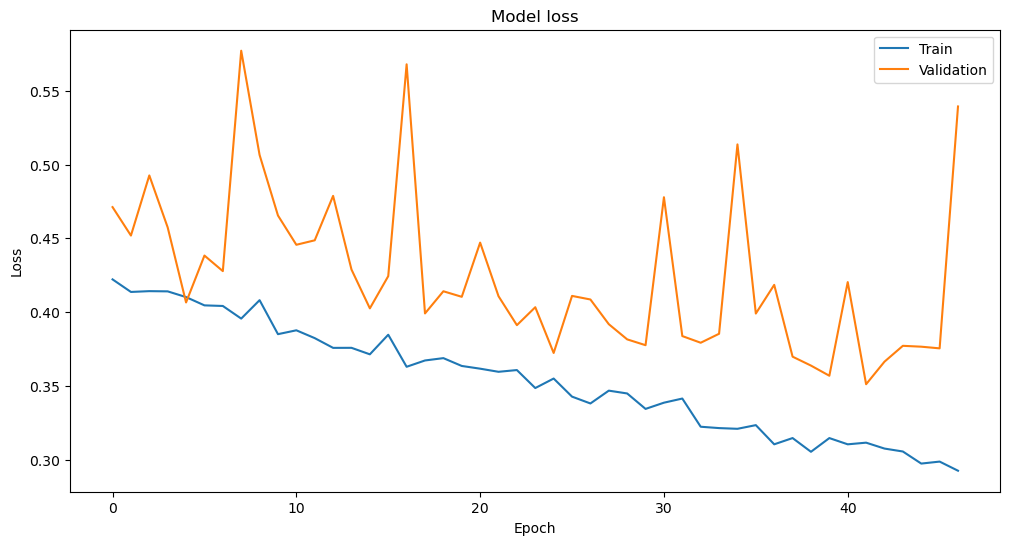

In [327]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [303]:
# Define list of stations names for confusion matrix
stations = {
0: 'BASEL',
1: 'BELGRADE',
2: 'BUDAPEST',
3: 'DEBILT',
4: 'DUSSELDORF',
5: 'HEATHROW',
6: 'KASSEL',
7: 'LJUBLJANA',
8: 'MAASTRICHT',
9: 'MADRID',
10: 'MUNCHENB',
11: 'OSLO',
12: 'SONNBLICK',
13: 'STOCKHOLM',
14: 'VALENTIA'
}

In [309]:
def confusion_matrix(y_true, y_pred, stations):
    # Check if y_true and y_pred are one-hot encoded or already class indices
    if y_true.ndim == 1:
        y_true_labels = y_true
    else:
        y_true_labels = np.argmax(y_true, axis=1)
    
    if y_pred.ndim == 1:
        y_pred_labels = y_pred
    else:
        y_pred_labels = np.argmax(y_pred, axis=1)
        
    # Map numeric labels to activity names
    y_true_series = pd.Series([stations[y] for y in y_true_labels])
    y_pred_series = pd.Series([stations[y] for y in y_pred_labels])
    
    return pd.crosstab(y_true_series, y_pred_series, rownames=['True'], colnames=['Pred'])

In [313]:
y_pred = model.predict(X_test)

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step


In [315]:
# Evaluate

print(confusion_matrix(y_test, y_pred, stations))

Pred        BASEL  BELGRADE  BUDAPEST  DEBILT  DUSSELDORF  HEATHROW  KASSEL  \
True                                                                          
BASEL        3564        89        16       3           1         0       0   
BELGRADE      316       773         1       0           0         0       0   
BUDAPEST       75        80        57       1           0         0       0   
DEBILT         34        24        13      11           0         0       0   
DUSSELDORF     14         5         9       1           0         0       0   
HEATHROW       34        11        10       2           1        17       0   
KASSEL          6         1         3       0           0         0       1   
LJUBLJANA      34         6         5       0           0         0       0   
MAASTRICHT      8         0         1       0           0         0       0   
MADRID        168        57        20       0           2         6       0   
MUNCHENB        7         1         0       0       

In [712]:
epochs = 30
batch_size = 16
n_hidden = 64

timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = len(y_train[0])

# Define the input shape
input_shape = (timesteps, input_dim)

# Create the model with additional pooling layers
model = Sequential([
    Input(shape=input_shape),
    Conv1D(n_hidden, kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(32, kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(n_classes, activation='tanh')
])

In [714]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [716]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=2)

Epoch 1/30
1076/1076 - 1s - 877us/step - accuracy: 0.5688 - loss: 23.9843
Epoch 2/30
1076/1076 - 1s - 543us/step - accuracy: 0.5725 - loss: 23.9065
Epoch 3/30
1076/1076 - 1s - 556us/step - accuracy: 0.5721 - loss: 23.9065
Epoch 4/30
1076/1076 - 1s - 603us/step - accuracy: 0.5719 - loss: 23.9065
Epoch 5/30
1076/1076 - 1s - 632us/step - accuracy: 0.5719 - loss: 23.9065
Epoch 6/30
1076/1076 - 1s - 641us/step - accuracy: 0.5719 - loss: 23.9065
Epoch 7/30
1076/1076 - 1s - 637us/step - accuracy: 0.5719 - loss: 23.9065
Epoch 8/30
1076/1076 - 1s - 637us/step - accuracy: 0.5719 - loss: 23.9065
Epoch 9/30
1076/1076 - 1s - 640us/step - accuracy: 0.5719 - loss: 23.9065
Epoch 10/30
1076/1076 - 1s - 626us/step - accuracy: 0.5719 - loss: 23.9065
Epoch 11/30
1076/1076 - 1s - 630us/step - accuracy: 0.5719 - loss: 23.9065
Epoch 12/30
1076/1076 - 1s - 548us/step - accuracy: 0.5719 - loss: 23.9065
Epoch 13/30
1076/1076 - 1s - 554us/step - accuracy: 0.5719 - loss: 23.9065
Epoch 14/30
1076/1076 - 1s - 553us

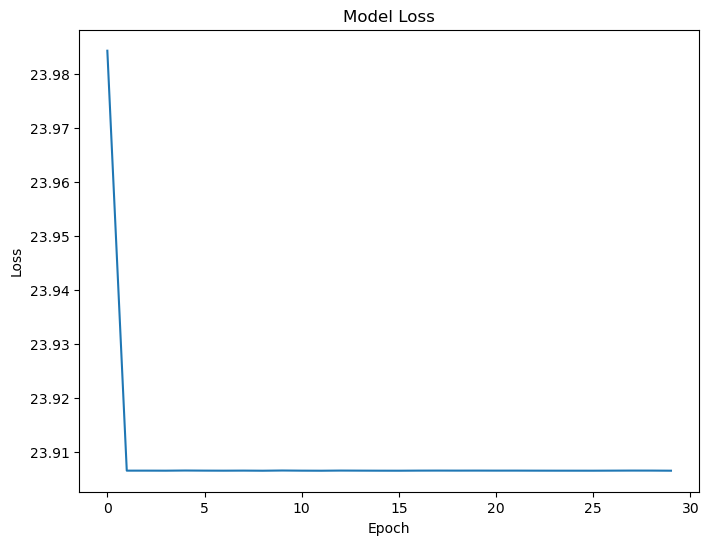

In [718]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [720]:
def confusion_matrix(y_true, y_pred):
    y_true = pd.Series([stations[y] for y in np.argmax(y_true, axis=1)])
    y_pred = pd.Series([stations[y] for y in np.argmax(y_pred, axis=1)])

    return pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Pred'])

In [722]:
# Evaluate
print(confusion_matrix(y_test, model.predict(X_test)))

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step
Pred        BASEL  MADRID
True                     
BASEL        3203     479
BELGRADE     1088       4
BUDAPEST      214       0
DEBILT         82       0
DUSSELDORF     29       0
HEATHROW       82       0
KASSEL         11       0
LJUBLJANA      61       0
MAASTRICHT      9       0
MADRID        436      22
MUNCHENB        8       0
OSLO            5       0
STOCKHOLM       4       0
VALENTIA        1       0


In [625]:
epochs = 30
batch_size = 32
n_hidden = 64

timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = len(y_train[0])

model = Sequential([
    Input(shape=(timesteps, input_dim)),
    LSTM(n_hidden),
    Dropout(0.5),
    Dense(n_classes, activation='tanh')
])

In [627]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [629]:
history2 = model.fit(X_train,
          y_train,
          batch_size=batch_size,
          validation_data=(X_test, y_test),
          epochs=epochs)

Epoch 1/30
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2068 - loss: 24.0818 - val_accuracy: 0.1389 - val_loss: 23.9926
Epoch 2/30
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0940 - loss: 24.9432 - val_accuracy: 0.1900 - val_loss: 30.8309
Epoch 3/30
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1166 - loss: 24.7778 - val_accuracy: 0.1924 - val_loss: 20.9059
Epoch 4/30
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1179 - loss: 24.9153 - val_accuracy: 0.2175 - val_loss: 24.6885
Epoch 5/30
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1121 - loss: 24.8812 - val_accuracy: 0.1889 - val_loss: 31.1146
Epoch 6/30
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0859 - loss: 24.5273 - val_accuracy: 0.0387 - val_loss: 23.4380
Epoch 7/30
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0662 - loss: 24.3103 - val_accuracy: 0.0676 - val_loss: 24.4892
Epoch 8/30
538/538 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0588 - loss: 25.2033 - v

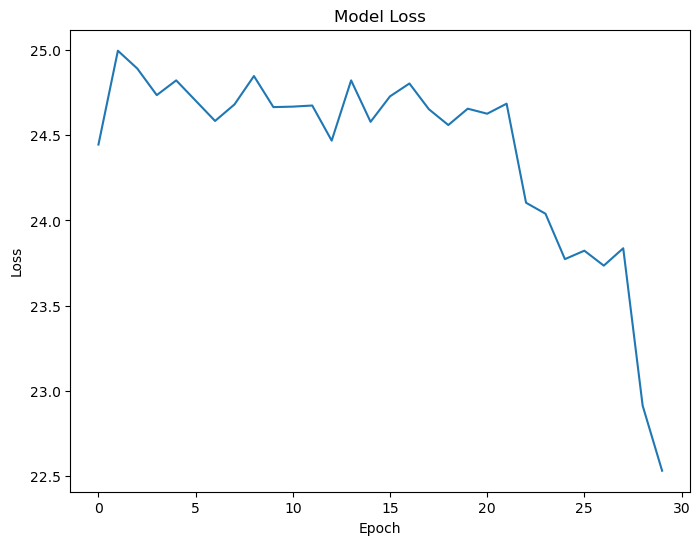

In [631]:
plt.figure(figsize=(8, 6))
plt.plot(history2.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [633]:
def confusion_matrix(y_true, y_pred):
    y_true = pd.Series([stations[y] for y in np.argmax(y_true, axis=1)])
    y_pred = pd.Series([stations[y] for y in np.argmax(y_pred, axis=1)])

    return pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Pred'])

In [635]:
# Evaluate
print(confusion_matrix(y_test, model.predict(X_test)))

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
Pred        BASEL  DUSSELDORF  KASSEL  LJUBLJANA  MAASTRICHT  MADRID  OSLO  \
True                                                                         
BASEL          33          57       1        256           1    1665   412   
BELGRADE        0           0       0         63           0     106   166   
BUDAPEST        0           0       0         27           0      13    52   
DEBILT          0           0       0          6           0       0    41   
DUSSELDORF      0           0       0          4           0       1     7   
HEATHROW        0           0       0         19           0       3    17   
KASSEL          0           0       0          3           0       1     0   
LJUBLJANA       0           0       0         22           0       3     3   
MAASTRICHT      0           0       0          1           0       0     1   
MADRID          1           0       0         94           0     143    32   
MUNCHENB        0    

In [761]:
epochs = 30
batch_size = 16
n_hidden = 64

timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = len(y_train[0])

model = Sequential()
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='tanh')) #Don't use relu here!

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [763]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [765]:
history2 = model.fit(X_train,
          y_train,
          batch_size=batch_size,
          validation_data=(X_test, y_test),
          epochs=epochs)

Epoch 1/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3307 - loss: 25.0399 - val_accuracy: 0.5535 - val_loss: 26.4056
Epoch 2/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4152 - loss: 25.3040 - val_accuracy: 0.6363 - val_loss: 29.7748
Epoch 3/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4285 - loss: 24.7438 - val_accuracy: 0.4076 - val_loss: 25.4489
Epoch 4/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2769 - loss: 24.9026 - val_accuracy: 0.5324 - val_loss: 26.6126
Epoch 5/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3004 - loss: 25.1340 - val_accuracy: 0.0490 - val_loss: 28.4814
Epoch 6/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1860 - loss: 24.9025 - val_accuracy: 0.0077 - val_loss: 30.0515
Epoch 7/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0307 - loss: 25.0590 - val_accuracy: 8.7138e-04 - val_loss: 27.6468
Epoch 8/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.0356

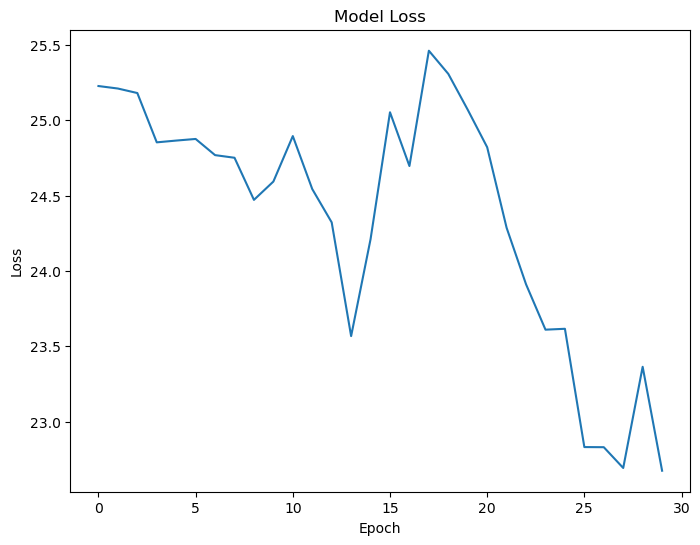

In [767]:
plt.figure(figsize=(8, 6))
plt.plot(history2.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [769]:
def confusion_matrix(y_true, y_pred):
    y_true = pd.Series([stations[y] for y in np.argmax(y_true, axis=1)])
    y_pred = pd.Series([stations[y] for y in np.argmax(y_pred, axis=1)])

    return pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Pred'])

In [771]:
# Evaluate
print(confusion_matrix(y_test, model.predict(X_test)))

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step
Pred        BASEL  BELGRADE
True                       
BASEL        3677         5
BELGRADE     1092         0
BUDAPEST      214         0
DEBILT         82         0
DUSSELDORF     29         0
HEATHROW       82         0
KASSEL         11         0
LJUBLJANA      61         0
MAASTRICHT      9         0
MADRID        458         0
MUNCHENB        8         0
OSLO            5         0
STOCKHOLM       4         0
VALENTIA        1         0
